# IMPORT LIBRARIES

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# READ DATA

In [4]:
df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')
df.head(2)

age  sex  chest_pain_type  resting_bp  max_heart_rate  exercise_angina  \
0   40    1                2         140             172                0   
1   49    0                3         160             156                0   

   oldpeak  ST_slope  MI  
0      0.0         1   0  
1      1.0         2   1

# SPLIT DATA

In [6]:
#define X, y
X = df.drop(columns=['MI'])  # Drop the 'MI' column to get the features
y = df['MI']  # Set 'MI' column as the target variable

#split 1: 85%, 15% (Train+Val, Test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#split 2: 76.5%, 23.5% (Train, Val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.235, random_state=42)

#(test, val, train: 65, 20, 15)

In [7]:
#print split size
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 576
Validation set size: 178
Test set size: 134


In [8]:
#intitialise classifier
rf = RandomForestClassifier(random_state=42)

#GridSerach parameters
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [5, 8, 10],
    'min_samples_leaf': [4, 8, 10],
    'max_features': ['sqrt', 'log2']
}

In [9]:
#initialise GridSearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

#save model
joblib.dump(grid_search, 'grid_search_model_tuned.pkl')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


['grid_search_model_tuned.pkl']

In [10]:
#get best model
best_rf = grid_search.best_estimator_
results_df = pd.DataFrame(grid_search.cv_results_)

#print results
print(best_rf)
#print best params
print("Best parameters:", grid_search.best_params_)
#print best cross-val
print("Best cross-validated score:", grid_search.best_score_)

#save best estimator
joblib.dump(grid_search.best_estimator_, 'best_rf_model_tuned.pkl')

RandomForestClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=5,
                       n_estimators=500, random_state=42)
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 500}
Best cross-validated score: 0.8611544227886057


['best_rf_model_tuned.pkl']

# VISUALISE GRIDSEARCH RESULTS

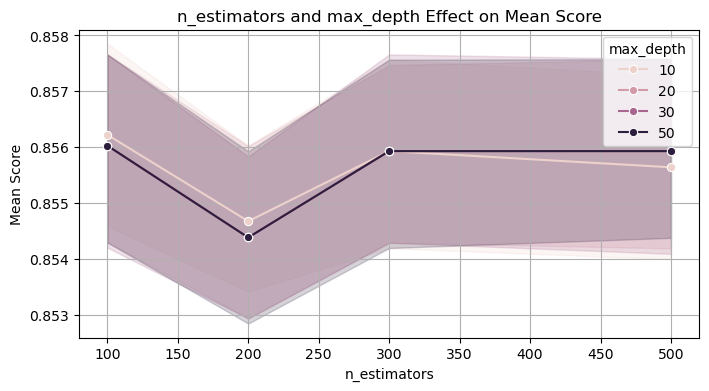

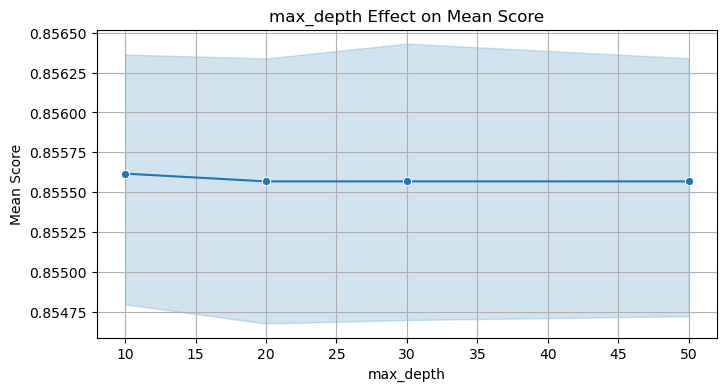

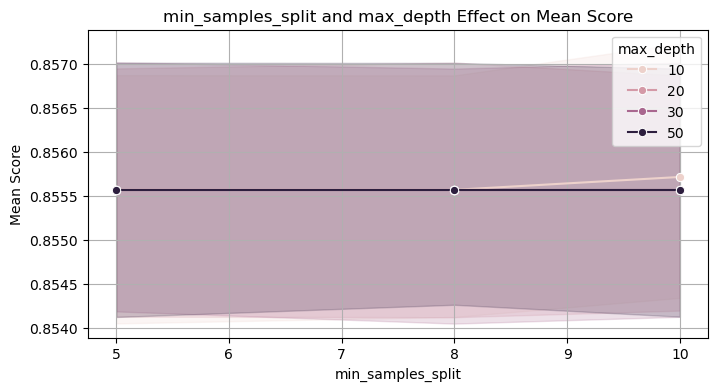

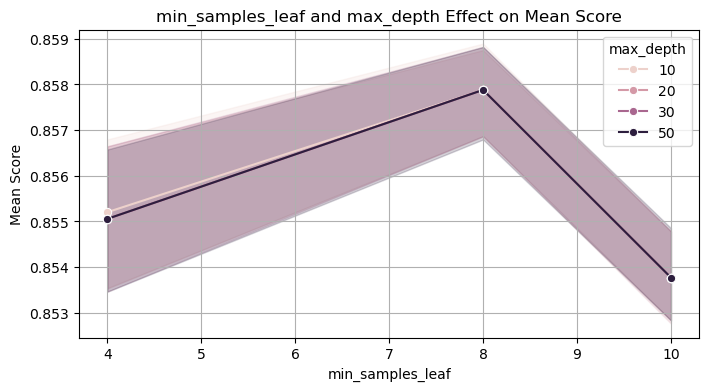

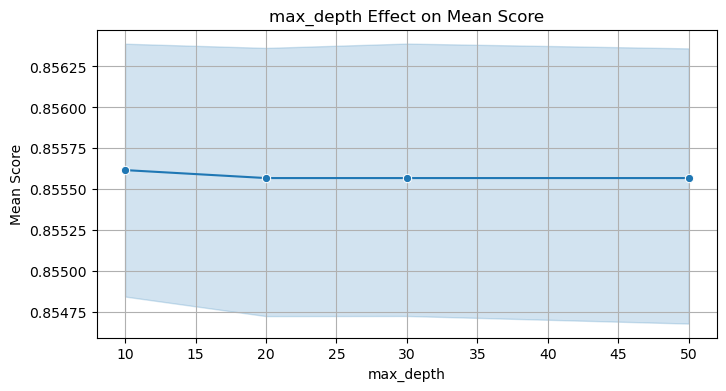

In [12]:
#n_estimators param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_n_estimators",
    y="mean_test_score",
    data=results_df,
    hue="param_max_depth",
    marker="o"
)
plt.title("n_estimators and max_depth Effect on Mean Score")
plt.xlabel("n_estimators")
plt.ylabel("Mean Score")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

#max_depth
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_max_depth",
    y="mean_test_score",
    data=results_df,
    marker="o"
)
plt.title("max_depth Effect on Mean Score")
plt.xlabel("max_depth")
plt.ylabel("Mean Score")
plt.grid(True)
plt.show()

#min_sample_split param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_min_samples_split",
    y="mean_test_score",
    data=results_df,
    hue="param_max_depth",
    marker="o"
)
plt.title("min_samples_split and max_depth Effect on Mean Score")
plt.xlabel("min_samples_split")
plt.ylabel("Mean Score")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

#min_sample_leaf param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_min_samples_leaf",
    y="mean_test_score",
    data=results_df,
    hue="param_max_depth",
    marker="o"
)
plt.title("min_samples_leaf and max_depth Effect on Mean Score")
plt.xlabel("min_samples_leaf")
plt.ylabel("Mean Score")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

#max_depth param
plt.figure(figsize=(8, 4))
sns.lineplot(
    x="param_max_depth",
    y="mean_test_score",
    data=results_df,
    marker="o"
)
plt.title("max_depth Effect on Mean Score")
plt.xlabel("max_depth")
plt.ylabel("Mean Score")
plt.grid(True)
plt.show()


# FIT RANDOM FOREST

In [14]:
#train
best_rf.fit(X_train, y_train)

#validation prediction
y_val_pred = best_rf.predict(X_val)

#val accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 82.58%


In [15]:
#val classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        84
           1       0.83      0.84      0.84        94

    accuracy                           0.83       178
   macro avg       0.83      0.82      0.83       178
weighted avg       0.83      0.83      0.83       178



In [16]:
#val confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Confusion Matrix:
[[68 16]
 [15 79]]


In [17]:
#cross-validation
model = joblib.load('best_rf_model_tuned.pkl')
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores for each fold:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.2f}")
print(f"Standard deviation of cross-validation accuracy: {cv_scores.std():.2f}")

Cross-validation scores for each fold: [0.8362069  0.84347826 0.84347826 0.90434783 0.87826087]
Mean cross-validation accuracy: 0.86
Standard deviation of cross-validation accuracy: 0.03


# TEST SET

In [19]:
# test predict
y_test_pred = best_rf.predict(X_test)

#test evaluate
report = classification_report(y_test, y_test_pred, output_dict=True)
cm = confusion_matrix(y_test, y_test_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nTest Classification Report:")
print(report)
print("\nTest Confusion Matrix:")
print(cm)

Test Accuracy: 88.81%

Test Classification Report:
{'0': {'precision': 0.8867924528301887, 'recall': 0.8392857142857143, 'f1-score': 0.8623853211009175, 'support': 56.0}, '1': {'precision': 0.8888888888888888, 'recall': 0.9230769230769231, 'f1-score': 0.9056603773584906, 'support': 78.0}, 'accuracy': 0.8880597014925373, 'macro avg': {'precision': 0.8878406708595388, 'recall': 0.8811813186813187, 'f1-score': 0.884022849229704, 'support': 134.0}, 'weighted avg': {'precision': 0.8880127663568947, 'recall': 0.8880597014925373, 'f1-score': 0.8875752792209974, 'support': 134.0}}

Test Confusion Matrix:
[[47  9]
 [ 6 72]]


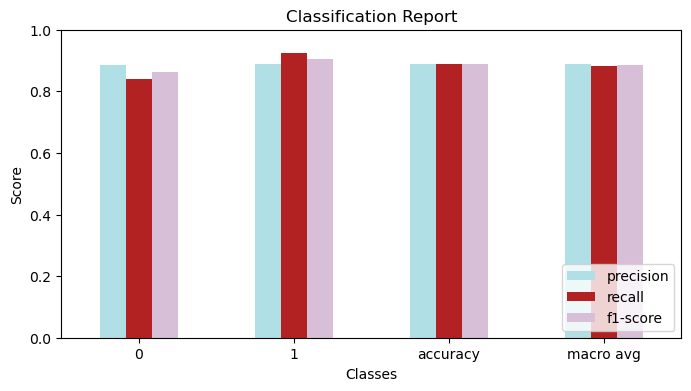

In [20]:
#convert report to DataFrame

report_df = pd.DataFrame(report).transpose()

#plot report
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(
    kind='bar', 
    figsize=(8, 4),
    color=['powderblue', 'firebrick', 'thistle'] )

plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Adjust the y-axis limit if needed
plt.legend(loc='lower right')
plt.show()

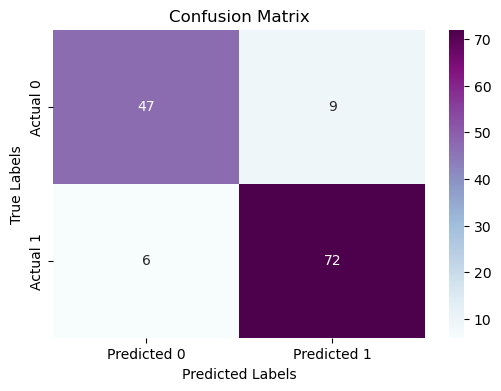

In [21]:
#plot cm
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
#ROC 
y_test_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

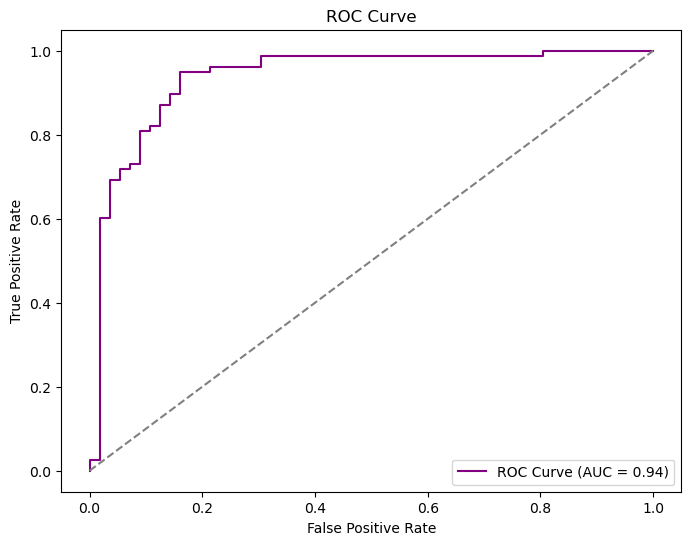

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()